In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg')

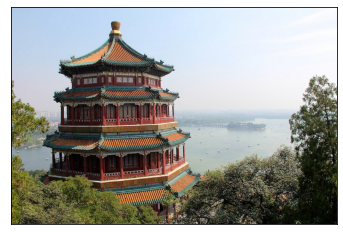

In [3]:
ax = plt.axes(xticks = [], yticks = [])
ax.imshow(china);

In [4]:
china.shape

(427, 640, 3)

In [5]:
data = china / 255.0   #To scale between 0 to 1
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [6]:
def plot_pixels(data, title, colors = None, N = 10000):
    if colors is None:
        colors = data
        
    #Choose random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))
    ax[0].scatter(R, G, color = colors, marker = '.')
    ax[0].set(xlabel = 'Red', ylabel = 'Green', xlim = (0, 1), ylim = (0, 1))
    
    ax[1].scatter(R, B, color = colors, marker = '.')
    ax[1].set(xlabel = 'Red', ylabel = 'Blue', xlim = (0, 1), ylim = (0, 1))
    
    fig.suptitle(title, size = 20)

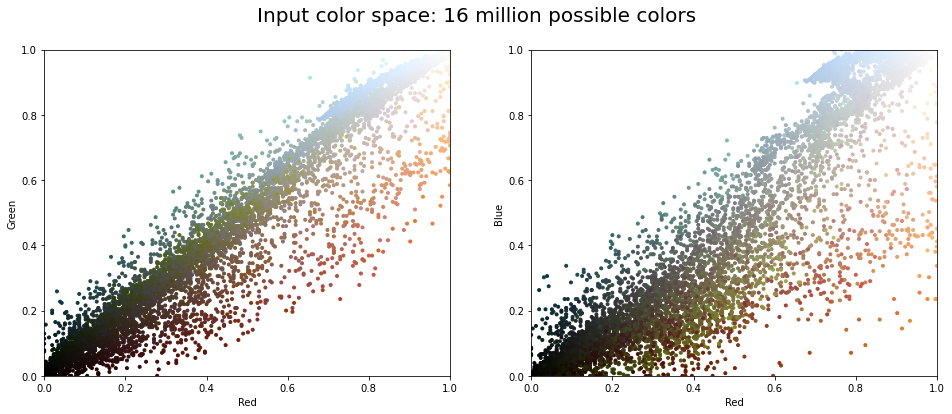

In [7]:
plot_pixels(data, title = 'Input color space: 16 million possible colors')

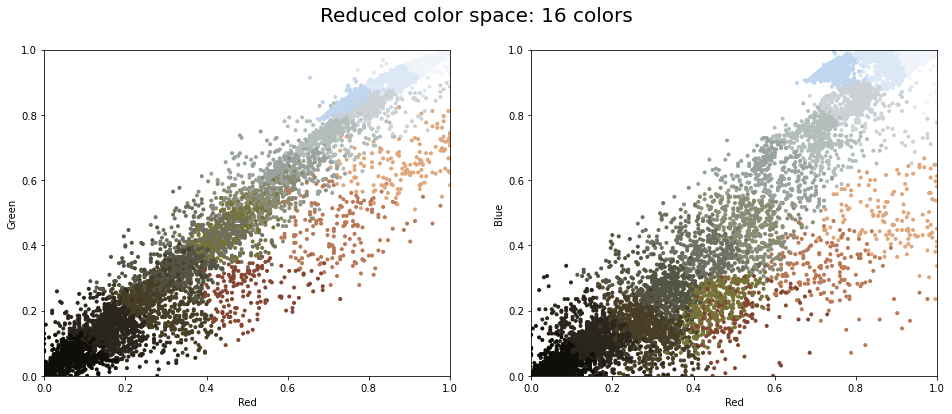

In [8]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors = new_colors, title = 'Reduced color space: 16 colors')

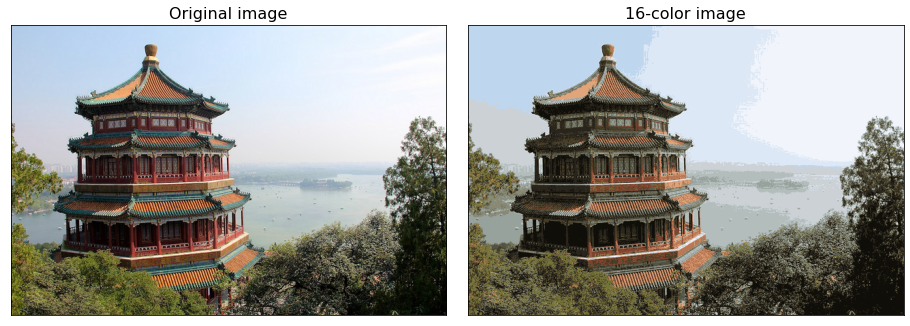

In [9]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize = (16, 6), subplot_kw = dict(xticks = [], yticks = []))
fig.subplots_adjust(wspace = 0.05)

ax[0].imshow(china)
ax[0].set_title('Original image', size = 16)

ax[1].imshow(china_recolored)
ax[1].set_title('16-color image', size = 16);

In [10]:
import seaborn as sns
sns.set();

In [14]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples = 400, centers = 4, cluster_std = 0.60, random_state = 0)
X = X[:, ::-1] #This is to flip the axes for better plotting

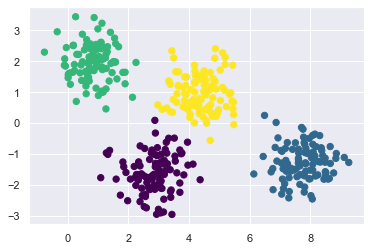

In [15]:
#plot the data with k-means labels
from sklearn.cluster import KMeans

kmeans = KMeans(4, random_state = 0)
labels = kmeans.fit(X).predict(X)

plt.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = 'viridis');

In [21]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters = 4, rseed = 0, ax = None):
    labels = kmeans.fit_predict(X)
    
    #plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = 'viridis', zorder = 2)
    
    #plot the representation of the k-means model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc = '#CCCCCC', edgecolor = 'black', lw = 3, alpha = 0.5, zorder = 1))

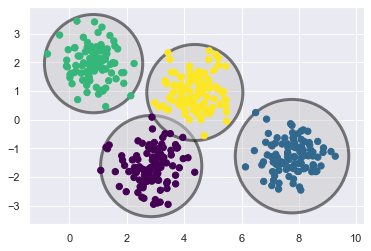

In [22]:
kmeans = KMeans(n_clusters = 4, random_state = 0)
plot_kmeans(kmeans, X)

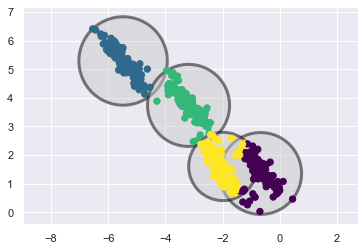

In [23]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters = 4, random_state = 0)
plot_kmeans(kmeans, X_stretched)

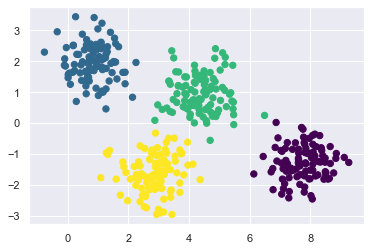

In [33]:
from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components = 4, covariance_type = 'full').fit(X)
labels = gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = 'viridis');

In [35]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.469 0.    0.531 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]]


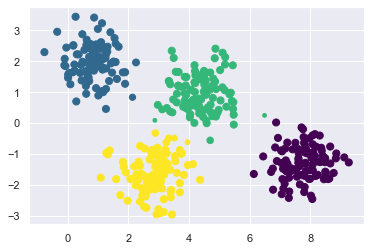

In [41]:
size = 50 * probs.max(1) ** 2 #square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c = labels, cmap = 'viridis', s = size);

In [46]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax = None, **kwargs):
    """Draws an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    #Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    #Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, label = True, ax = None):
    ax = ax or plt.gca()
    
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = 'viridis', zorder = 2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s = 40, zorder = 2)
        
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha = w * w_factor)

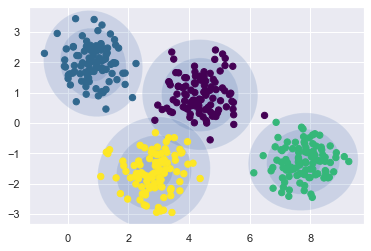

In [47]:
gmm = GMM(n_components = 4, random_state = 42)
plot_gmm(gmm, X)

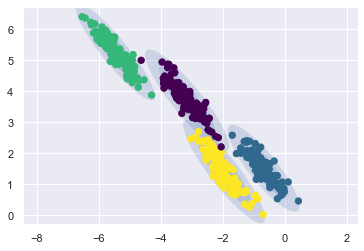

In [48]:
gmm = GMM(n_components = 4, covariance_type = 'full', random_state = 42)
plot_gmm(gmm, X_stretched)

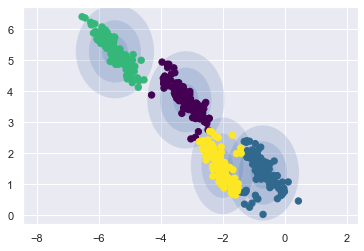

In [49]:
gmm = GMM(n_components = 4, covariance_type = 'diag', random_state = 42)
plot_gmm(gmm, X_stretched)

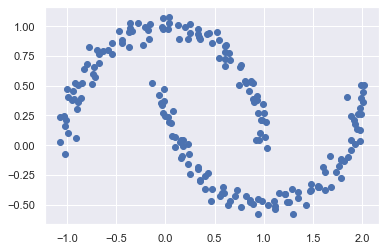

In [57]:
from sklearn.datasets import make_moons

Xmoon, ymoon = make_moons(200, noise = .05, random_state = 0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

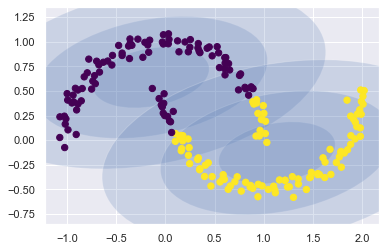

In [58]:
gmm2 = GMM(n_components = 2, covariance_type = 'full', random_state = 0)
plot_gmm(gmm2, Xmoon)

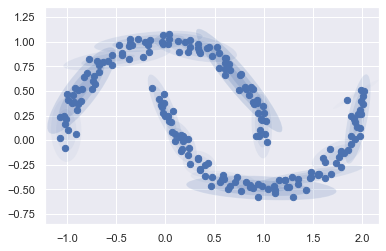

In [63]:
gmm16 = GMM(n_components = 16, covariance_type = 'full', random_state = 0)
plot_gmm(gmm16, Xmoon, label = False)

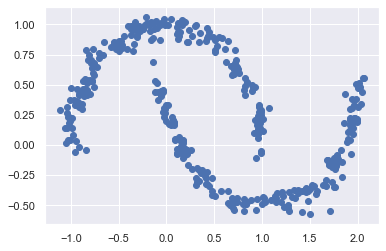

In [72]:
Xnew = gmm16.sample(400)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1]);

In [73]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type = 'full', random_state = 0).fit(Xmoon) for n in n_components]

C:\Users\U\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


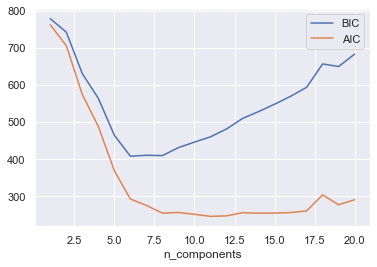

In [74]:
plt.plot(n_components, [m.bic(Xmoon) for m in models], label = 'BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label = 'AIC')
plt.legend(loc = 'best')
plt.xlabel('n_components');

In [81]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

In [82]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize = (8, 8), subplot_kw = dict(xticks = [], yticks = []))
    fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
    
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap = 'binary')
        im.set_clim(0, 16)

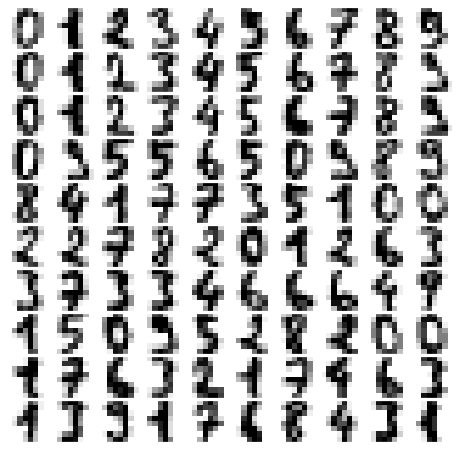

In [84]:
plot_digits(digits.data)

In [85]:
#Reducing the dataset first cos GMMs usually exhibit difficulties converging in a high dimensional space
from sklearn.decomposition import PCA

pca = PCA(0.99, whiten = True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

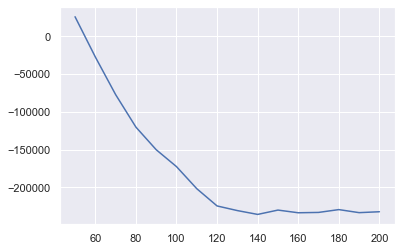

In [86]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type = 'full', random_state = 0) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]

plt.plot(n_components, aics);

In [93]:
gmm = GMM(110, covariance_type = 'full', random_state = 0)
gmm.fit(data)

print(gmm.converged_)

True


In [96]:
data_new = gmm.sample(100)
data_new[0].shape

(100, 41)

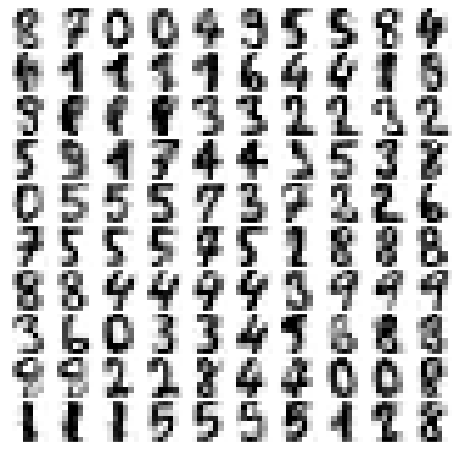

In [98]:
digits_new = pca.inverse_transform(data_new[0])

plot_digits(digits_new)

In [99]:
def make_data(N, f = 0.3, rseed = 1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    
    return x

In [100]:
x = make_data(1000)

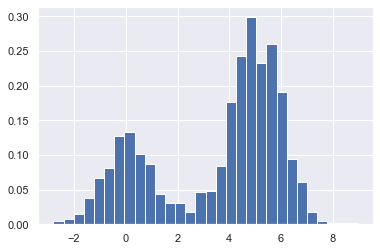

In [114]:
hist = plt.hist(x, bins = 30, density = True)   #density = True to get a normed distribution

In [115]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]

(density * widths).sum()

1.0

In [116]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

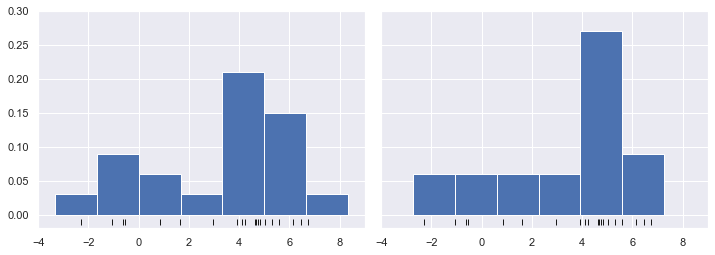

In [122]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex = True, sharey = True, 
                       subplot_kw = dict(xlim = (-4, 9), ylim = (-0.02, 0.3)))

fig.subplots_adjust(wspace = 0.05)

for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins = bins + offset, density = True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth = 1)

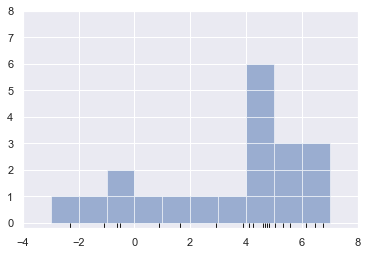

In [126]:
fig, ax = plt.subplots()

bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth = 1)

for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha = 0.5))
        
ax.set(xlim = (-4, 8), ylim = (-0.2, 8));

In [127]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

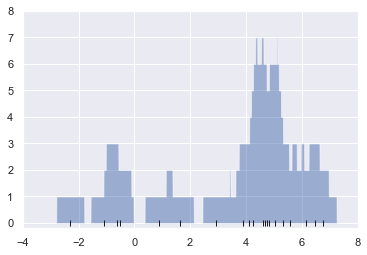

In [128]:
plt.fill_between(x_d, density, alpha = 0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth = 1)

plt.axis([-4, 8, -0.2, 8]);

In [130]:
from scipy.stats import norm

x_d = np.linspace(-4, 8, 2000)
density = sum(norm(xi).pdf(x_d) for xi in x)

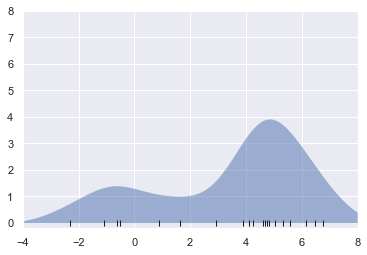

In [131]:
plt.fill_between(x_d, density, alpha = 0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth = 1)

plt.axis([-4, 8, -0.2, 8]);